In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

# Global constants
sleep_threshold = 4
ref_bandwidth = 3
active_node_cost = 210
active_link_cost = 25

In [14]:
# Graph representing the true network topology, with weights representing bandwidth and current usage.
# Assume the path delay is all the same

G = nx.Graph()
routers = {}
router_ids = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

# Add nodes (routers) to the graph
G.add_nodes_from(router_ids)

# Add edges (links between routers) with weights (costs)
G.add_edge('A', 'B', band=4, usage = 0)
G.add_edge('A', 'C', band=3, usage = 0)
G.add_edge('B', 'C', band=3, usage = 0)
G.add_edge('B', 'D', band=5, usage = 0)
G.add_edge('C', 'D', band=4, usage = 0)
G.add_edge('C', 'E', band=2, usage = 0)
G.add_edge('D', 'E', band=3, usage = 0)
G.add_edge('E', 'F', band=2, usage = 0)
G.add_edge('D', 'F', band=3, usage = 0)
G.add_edge('I', 'L', band=3, usage = 0)
G.add_edge('E', 'G', band=2, usage = 0)
G.add_edge('D', 'G', band=3, usage = 0)
G.add_edge('G', 'H', band=4, usage = 0)
G.add_edge('G', 'I', band=3, usage = 0)
G.add_edge('F', 'J', band=3, usage = 0)
G.add_edge('J', 'K', band=3, usage = 0)
G.add_edge('J', 'C', band=3, usage = 0)
G.add_edge('K', 'L', band=3, usage = 0)
G.add_edge('A', 'L', band=3, usage = 0)

def reset_usage():
    for u, v, data in G.edges(data=True):
        data['usage'] = 0

def get_details():
    sleeping = 0
    packets_sending = 0
    packets_lost = 0
    for id in routers:
        if routers[id].sleep:
            sleeping += 1
        packets_sending += len(routers[id].packet_dest)
        packets_lost += routers[id].packet_loss
    links_asleep = sum(1 for u, v, d in G.edges(data=True) if d['usage'] == 0)
    energy_usage = (len(routers)-sleeping)*active_node_cost + (G.number_of_edges()-links_asleep)*active_link_cost

    total_band = sum(data['band'] for u, v, data in G.edges(data=True))
    total_usage = sum(data['usage'] for u, v, data in G.edges(data=True))
    link_util = round(total_usage/total_band,3)

    return packets_sending, energy_usage, link_util

def print_details():
    total_band = sum(data['band'] for u, v, data in G.edges(data=True))
    total_usage = sum(data['usage'] for u, v, data in G.edges(data=True))

    print(f"Total band: {total_band}, Total usage: {total_usage}, Link utilization: {round(total_usage/total_band,3)}")
    
    #Router info
    sleeping = 0
    packets_sending = 0
    packets_lost = 0
    for id in routers:
        if routers[id].sleep:
            sleeping += 1
        packets_sending += len(routers[id].packet_dest)
        packets_lost += routers[id].packet_loss
    print(f"Total routers: {len(routers)}, Sleeping: {sleeping}")
    print(f"Packets sent: {packets_sending}, Packets lost: {packets_lost}")
    links_asleep = sum(1 for u, v, d in G.edges(data=True) if d['usage'] == 0)
    print(f"Total links: {G.number_of_edges()}, Sleeping: {links_asleep}")
    print(f"Total energy cost: {(len(routers)-sleeping)*active_node_cost + (G.number_of_edges()-links_asleep)*active_link_cost} watts")

# Plot the graph topology and relevant information
def plot_topo():
    np.random.seed(20)
    
    pos = nx.spring_layout(G)  # Define node positions using a spring layout
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="pink")  # Draw nodes
    labels = nx.get_edge_attributes(G, 'band')  # Get edge weights as labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)  # Draw edge labels
    plt.title("Network Topology Bandwidth")
    plt.show()

    nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue")  # Draw nodes
    labels = nx.get_edge_attributes(G, 'usage')  # Get edge weights as labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)  # Draw edge labels
    plt.title("Network Topology Usage")
    plt.show()

    print_details()

In [15]:
class Router:
    def __init__(self, id, G):
        self.id = id # String identifier
        self.link_state_db = G # For simplicity, assume each router start with a converged topo
        self.sleep = False # Eco-router sleep status for Eco-RP

        self.packet_dest= {} # Destinations being sent packets originated from this router
        self.packet_loss= 0

    def calc_cost(self):
        # Define link cost as ref_bandwidth / (bandwidth - usage)
        for u, v, data in G.edges(data=True):
            if routers[u].sleep or routers[v].sleep:
                data['cost'] = 100
            elif data['band'] - data['usage'] == 0:
                data['cost'] = float('inf')
            else:
                data['cost'] = ref_bandwidth / (data['band'] - data['usage'])
         
    def plot_ls_db(self):
        self.calc_cost()
        # Plot the graph with cost
        np.random.seed(20)
        
        pos = nx.spring_layout(self.link_state_db)  # Define node positions using a spring layout
        nx.draw(self.link_state_db, pos, with_labels=True, node_size=700, node_color="lightblue")  # Draw nodes
        labels = nx.get_edge_attributes(self.link_state_db, 'cost')  # Get edge weights as labels
        nx.draw_networkx_edge_labels(self.link_state_db, pos, edge_labels=labels)  # Draw edge labels
        plt.title(f"Link State Database of Router {self.id} with Costs")
        plt.show()

    def randomize_packet_dest(self, pkt_count):
        self.packet_dest = {}
        for pkt in range(pkt_count):
            random_id = random.choice([item for item in router_ids if item != self.id])
            if random_id in self.packet_dest:
                self.packet_dest[random_id] += 1
            else:
                self.packet_dest[random_id] = 1

    def add_packet_dest(self, dest_id):
        if dest_id in self.packet_dest:
            self.packet_dest[dest_id] += 1
        else:
            self.packet_dest[dest_id] = 1

    def send_packets(self):
        # Compute shortest path using Djikstra algorithm
        def get_path(target_id):
            return nx.shortest_path(self.link_state_db, source=self.id, target=target_id, weight='cost')
        
        self.packet_loss = 0
        for dest in self.packet_dest:
            for pkt_count in range(self.packet_dest[dest]):
                self.calc_cost()
                path = get_path(dest)
                path_avail = True
                for u, v in zip(path[:-1], path[1:]):
                    if G[u][v]['usage'] >= G[u][v]['band'] or routers[u].sleep or routers[v].sleep:
                        print(f"Max usage: {dest} unreachable from {self.id}")
                        self.packet_loss += 1
                        path_avail = False
                        break
                
                if path_avail:
                    for u, v in zip(path[:-1], path[1:]):
                        G[u][v]['usage'] += 1
                    print(f"Sending packet: {self.id} to {dest}")

    def put_sleep(self):
        print(f"{self.id} put to sleep")
        self.sleep = True

    def awake(self):
        print(f"{self.id} woken up")
        self.sleep = False

Sending packet: E to L
Sending packet: E to B
Sending packet: H to G
Sending packet: H to G
Sending packet: J to F
Sending packet: J to H


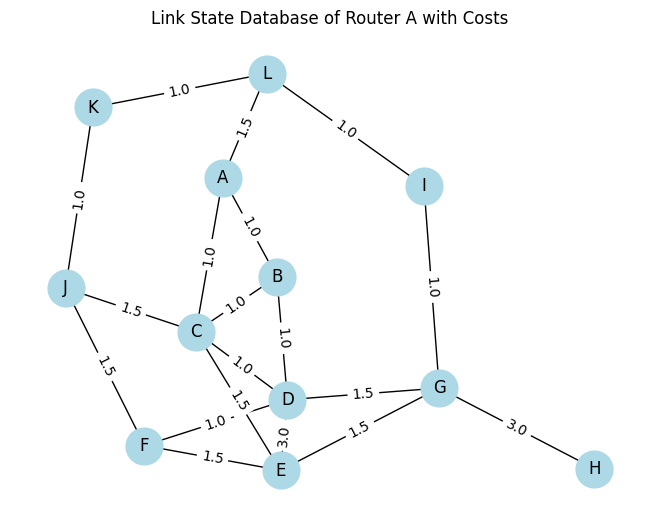

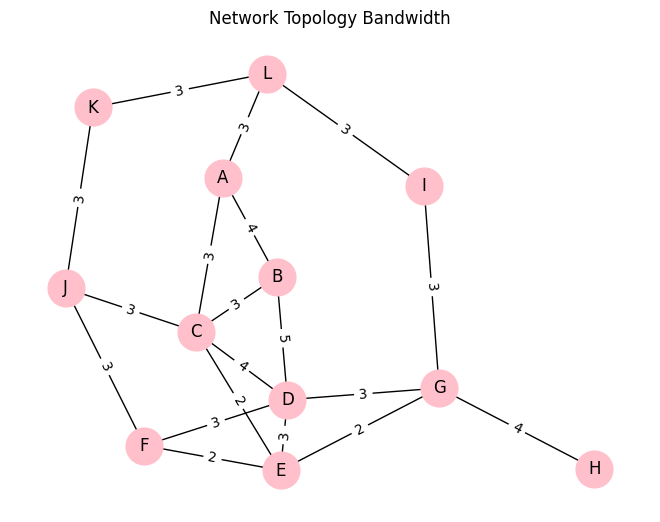

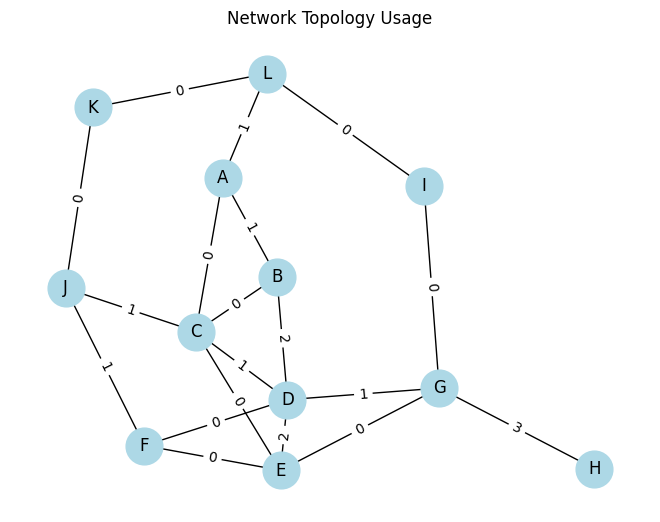

Total band: 59, Total usage: 13, Link utilization: 0.22
Total routers: 12, Sleeping: 0
Packets sent: 5, Packets lost: 0
Total links: 19, Sleeping: 10
Total energy cost: 2745 watts


In [16]:
# Basic OSPF

random.seed(20)

for id in router_ids:
    routers[id] = Router(id, G)
    if random.random() < 0.3:
        routers[id].randomize_packet_dest(2)

def send_all_pkt():
    reset_usage()
    for id in router_ids:
        routers[id].send_packets()   

send_all_pkt()

routers['A'].plot_ls_db()
plot_topo()

In [17]:
print(len(routers['E'].packet_dest))

2


K put to sleep
C put to sleep
I put to sleep


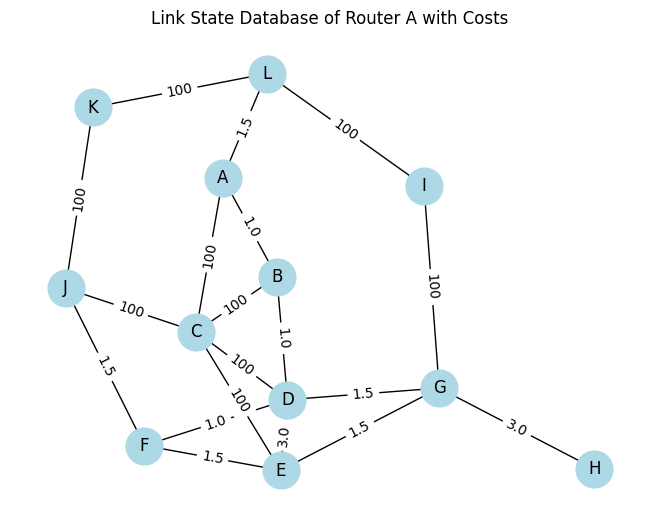

Sending packet: E to L
Sending packet: E to B
Sending packet: H to G
Sending packet: H to G
Sending packet: J to F
Sending packet: J to H


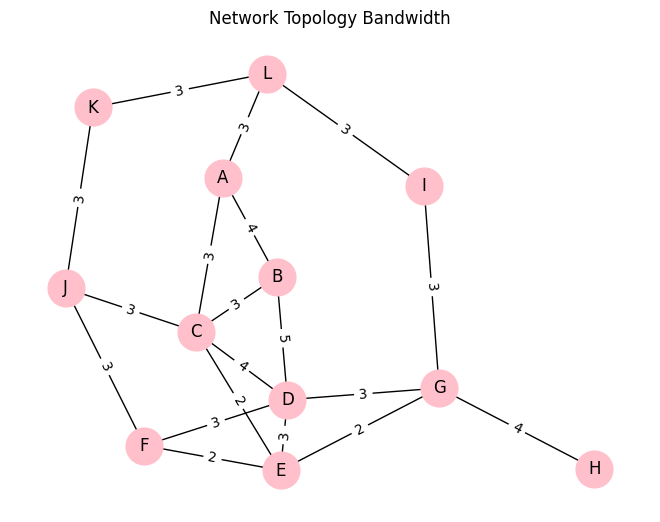

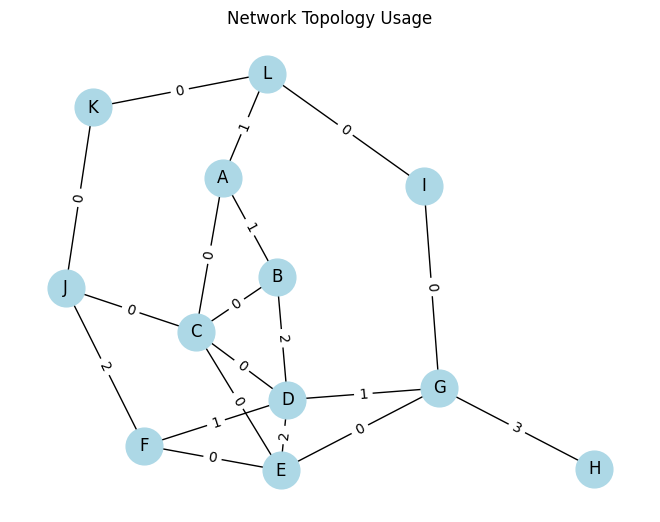

Total band: 59, Total usage: 13, Link utilization: 0.22
Total routers: 12, Sleeping: 3
Packets sent: 5, Packets lost: 0
Total links: 19, Sleeping: 11
Total energy cost: 2090 watts


In [18]:
#ECO-RP simulation: put eco routers with low traffic to sleep
        
routers['K'].put_sleep()
routers['C'].put_sleep()
routers['I'].put_sleep()
routers['A'].plot_ls_db()
send_all_pkt()
plot_topo()


Sending packet: E to L
Sending packet: E to B
Sending packet: H to G
Sending packet: H to G
Sending packet: J to F
Sending packet: J to H
Sending packet: J to L
Max usage: L unreachable from J
Max usage: L unreachable from J


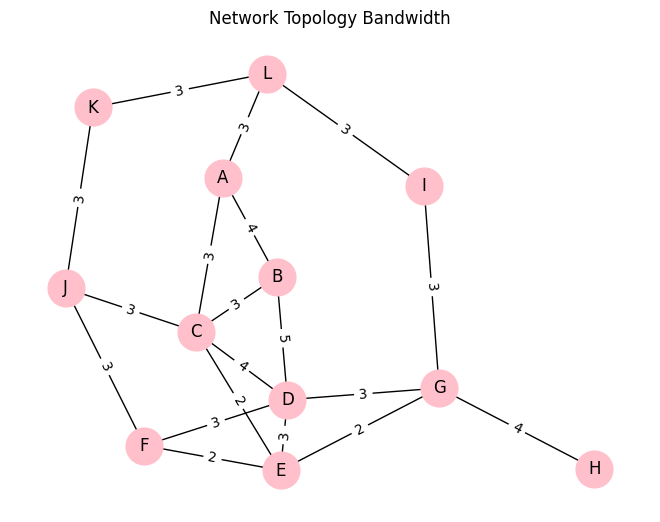

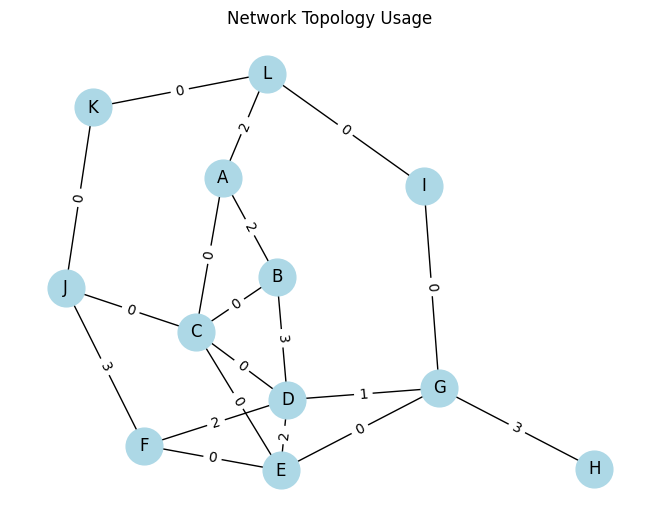

Total band: 59, Total usage: 18, Link utilization: 0.305
Total routers: 12, Sleeping: 3
Packets sent: 6, Packets lost: 2
Total links: 19, Sleeping: 11
Total energy cost: 2090 watts


In [19]:
# Let's say J begins sending lots of traffic to L
routers['J'].add_packet_dest('L')
routers['J'].add_packet_dest('L')
routers['J'].add_packet_dest('L')
send_all_pkt()
plot_topo()

Sending packet: E to L
Sending packet: E to B
Sending packet: H to G
Sending packet: H to G
Sending packet: J to F
Sending packet: J to H
Sending packet: J to L
K woken up
Sending packet: J to L
Sending packet: J to L


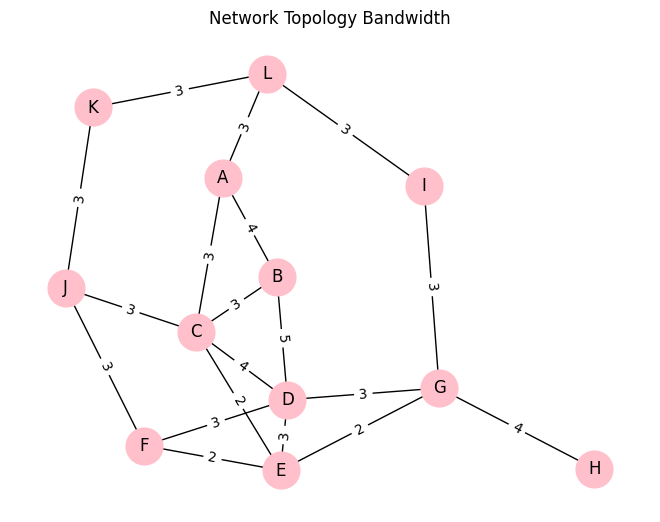

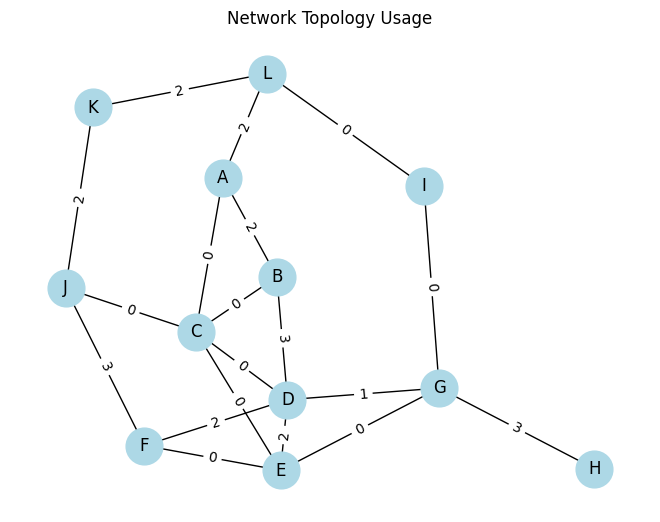

Total band: 59, Total usage: 22, Link utilization: 0.373
Total routers: 12, Sleeping: 2
Packets sent: 6, Packets lost: 0
Total links: 19, Sleeping: 9
Total energy cost: 2350 watts


In [20]:
# Adding a new method to wake sleeping routers if needed

def send_packets_and_wake(self):
    # Compute shortest path using Djikstra algorithm
    def get_path(target_id):
        return nx.shortest_path(self.link_state_db, source=self.id, target=target_id, weight='cost')
    
    self.packet_loss = 0
    for dest in self.packet_dest:
        for pkt_count in range(self.packet_dest[dest]):
            self.calc_cost()
            path = get_path(dest)
            path_avail = True
            for u, v in zip(path[:-1], path[1:]):
                if G[u][v]['usage'] >= G[u][v]['band']:
                    print(f"Max usage: {dest} unreachable from {self.id}")
                    self.packet_loss += 1
                    path_avail = False
                    break
            
            if path_avail:
                for u, v in zip(path[:-1], path[1:]):
                    G[u][v]['usage'] += 1
                    if routers[u].sleep:
                        routers[u].awake()
                    if routers[v].sleep:
                        routers[v].awake()
                print(f"Sending packet: {self.id} to {dest}")

Router.send_packets_and_wake = send_packets_and_wake

def send_all_pkt():
    reset_usage()
    for id in router_ids:
        routers[id].send_packets_and_wake()   

send_all_pkt()
plot_topo()

In [21]:
#Simulate for different amounts of traffic

pkt_chances = np.arange(0, 0.5 + 0.05, 0.02)

packets = pkt_chances * 2
ospf_energy = []
eco_rp_energy = []
ospf_linkut = []
eco_rp_linkut = []
random.seed(22)

for pc in pkt_chances:
    for id in router_ids:
        routers[id] = Router(id, G)
        if random.random() < pc:
            routers[id].randomize_packet_dest(2)

    send_all_pkt()
    print_details()
    pkt, energy, linkutil = get_details()
    ospf_energy.append(energy)
    ospf_linkut.append(linkutil)

    for id in router_ids:
        if len(routers[id].packet_dest) > 0: continue

        total_usage = 0
        for _, _, data in G.edges(id, data=True):
            total_usage += data.get('usage')  # Assuming default weight is 1 if not specified
        if total_usage <= sleep_threshold:
            routers[id].put_sleep()

    send_all_pkt()
    print_details()
    pkt, energy, linkutil = get_details()
    eco_rp_energy.append(energy)
    eco_rp_linkut.append(linkutil)

Total band: 59, Total usage: 0, Link utilization: 0.0
Total routers: 12, Sleeping: 0
Packets sent: 0, Packets lost: 0
Total links: 19, Sleeping: 19
Total energy cost: 2520 watts
A put to sleep
B put to sleep
C put to sleep
D put to sleep
E put to sleep
F put to sleep
G put to sleep
H put to sleep
I put to sleep
J put to sleep
K put to sleep
L put to sleep
Total band: 59, Total usage: 0, Link utilization: 0.0
Total routers: 12, Sleeping: 12
Packets sent: 0, Packets lost: 0
Total links: 19, Sleeping: 19
Total energy cost: 0 watts
Total band: 59, Total usage: 0, Link utilization: 0.0
Total routers: 12, Sleeping: 0
Packets sent: 0, Packets lost: 0
Total links: 19, Sleeping: 19
Total energy cost: 2520 watts
A put to sleep
B put to sleep
C put to sleep
D put to sleep
E put to sleep
F put to sleep
G put to sleep
H put to sleep
I put to sleep
J put to sleep
K put to sleep
L put to sleep
Total band: 59, Total usage: 0, Link utilization: 0.0
Total routers: 12, Sleeping: 12
Packets sent: 0, Packe

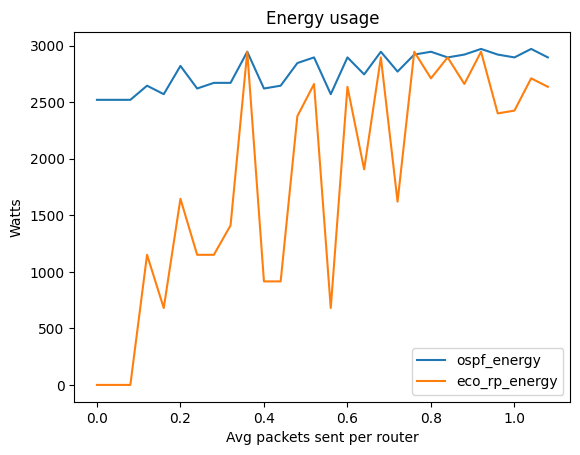

In [22]:
#Chart the experiment data
plt.plot(packets, ospf_energy, label='ospf_energy')
plt.plot(packets, eco_rp_energy, label='eco_rp_energy')
plt.xlabel('Avg packets sent per router')
plt.ylabel('Watts')
plt.title('Energy usage')
plt.legend()
plt.show()